Cryptocurrency has gain its popularity in the last few years. As a data analyst, I have always been interested in ways to predict the prices. The following picture is a snapshot of the top 7 cryptocurrcenies according to market cap (source: https://www.coingecko.com/). The website has provided great api to retrieve pricing history so I decided to use it to pull all the pricing data.
Another 

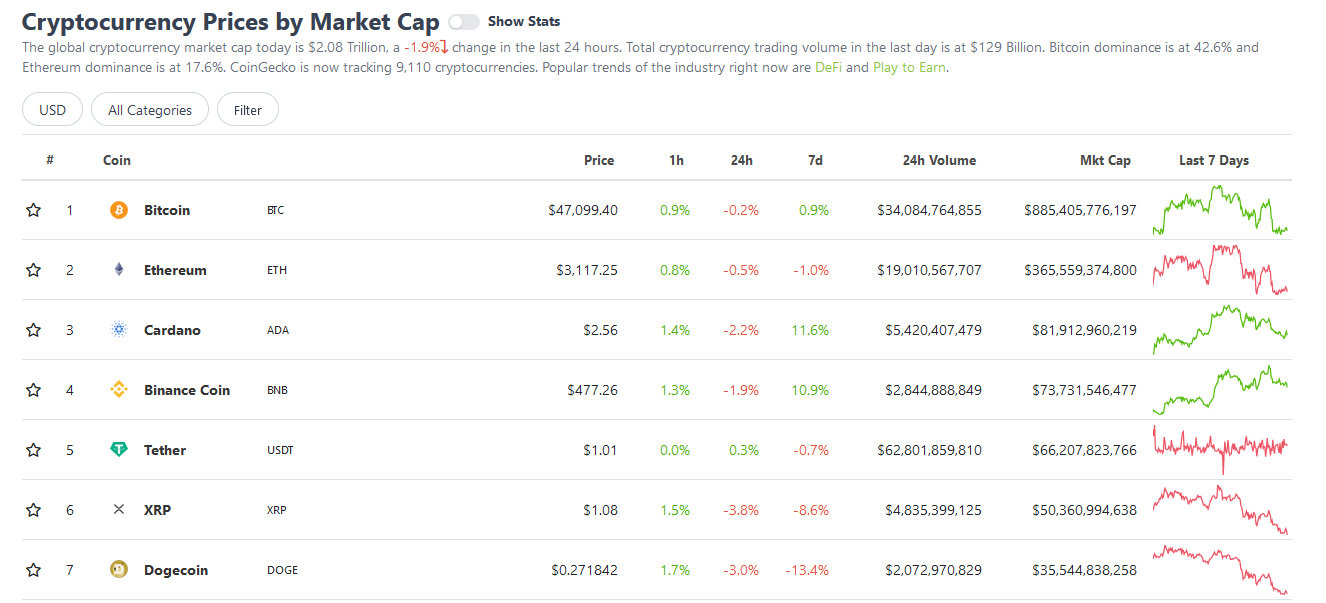

In [1]:
# Import all the necessary package for the project

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, Ridge 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# pull the las 100 days pricing data of the top 7 cryptocurrencies using coingecko's api

cryptos = ['bitcoin', 'ethereum', 'cardano', 'binancecoin', 'tether', 'ripple', 'dogecoin']   #ripple is XRP 
crypto_df = []
for crypto in cryptos:
    url = 'https://api.coingecko.com/api/v3/coins/' + crypto + '/market_chart?vs_currency=usd&days=100'
    result = requests.get(url).json()
    prices = result['prices']
    prices_df = pd.DataFrame(prices, columns=['Time_Stamp', '{}_price'.format(crypto)])
    prices_df['Time_Stamp'] = pd.to_datetime(prices_df['Time_Stamp'], unit='ms').dt.round('H')
    #round to 1 hour
    crypto_df.append(prices_df)
    
#join all the info into a df    
#keep bitcoin on left because that's the target we want to predict
crypto_price_df = pd.merge(crypto_df[0], crypto_df[1], how='left', on='Time_Stamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[2], how='left', on='Time_Stamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[3], how='left', on='Time_Stamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[4], how='left', on='Time_Stamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[5], how='left', on='Time_Stamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[6], how='left', on='Time_Stamp')

crypto_price_df.head(5)

,Time_Stamp,bitcoin_price,ethereum_price,cardano_price,binancecoin_price,tether_price,ripple_price,dogecoin_price
0,2021-05-28,38642.895554,2742.990863,1.650521,367.292287,0.999276,0.971567,0.333812
1,2021-05-29,35710.220937,2433.328866,1.515383,330.473645,1.000631,0.895622,0.311455
2,2021-05-30,34775.079413,2294.626286,1.415685,305.848975,0.999162,0.834466,0.302704
3,2021-05-31,35714.752020,2395.853228,1.576847,325.574027,0.998049,0.905470,0.301429
4,2021-06-01,37340.679266,2708.429866,1.743824,353.081176,0.997550,1.041413,0.326531


In [3]:
#Next I used coingecko's api to collect community's info regarding crypto

#Turned the datetime format into api's format
api_url = 'https://api.coingecko.com/api/v3/coins/bitcoin/history?date='
time_value = crypto_price_df['Time_Stamp'].values
dates = pd.date_range(time_value[0], time_value[-1]).round("D")
date_list = dates.strftime('%d-%m-%Y').tolist()

In [4]:
#Let's take a look at an exmaple in one of the date

requests.get(api_url + date_list[0]).json()['community_data']

{'facebook_likes': None,
 'twitter_followers': 93009,
 'reddit_average_posts_48h': 6.364,
 'reddit_average_comments_48h': 1386.909,
 'reddit_subscribers': 2991299,
 'reddit_accounts_active_48h': '8727.08333333333'}

In [5]:
#Except for facebook_likes, I could use the other 5 fields as the features

#Download all the community info through api
feature1_data, feature2_data, feature3_data, feature4_data, feature5_data =[],[],[],[],[]
for date in date_list:
    #api would stop working sometimes, so add a loop to reqeust info several times
    for i in range(100):
        try:
            community_data = requests.get(api_url + date).json()['community_data']
            break
        except:
            time.sleep(5) 
    feature1 = community_data['twitter_followers']
    feature2 = community_data['reddit_average_posts_48h']
    feature3 = community_data['reddit_average_comments_48h']
    feature4 = community_data['reddit_subscribers']
    feature5 = community_data['reddit_accounts_active_48h']
    feature1_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature1])
    feature2_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature2])
    feature3_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature3])
    feature4_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature4])
    feature5_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature5])

In [6]:
#putting all community info from those dates into dataframe
featuer1_df = pd.DataFrame(feature1_data, columns=['Time_Stamp','twitter_followers'])
featuer2_df = pd.DataFrame(feature2_data, columns=['Time_Stamp','reddit_average_posts_48h'])
featuer3_df = pd.DataFrame(feature3_data, columns=['Time_Stamp','reddit_average_comments_48h'])
featuer4_df = pd.DataFrame(feature4_data, columns=['Time_Stamp','reddit_subscribers'])
featuer5_df = pd.DataFrame(feature5_data, columns=['Time_Stamp','reddit_accounts_active_48h'])

#merge all the dataframe into one
feature_df = pd.merge(featuer1_df,featuer2_df, how='left', on='Time_Stamp')
feature_df = pd.merge(feature_df, featuer3_df, how='left', on='Time_Stamp')
feature_df = pd.merge(feature_df, featuer4_df, how='left', on='Time_Stamp')
feature_df = pd.merge(feature_df, featuer5_df, how='left', on='Time_Stamp')

#merge the price and feature into one
all_df = pd.merge(crypto_price_df, feature_df, how='left', on='Time_Stamp')

all_df.tail()

,Time_Stamp,bitcoin_price,ethereum_price,cardano_price,binancecoin_price,tether_price,ripple_price,dogecoin_price,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h
96,2021-09-01 00:00:00,47335.420299,3440.562336,2.785254,466.325068,1.002210,1.191610,0.279038,3129705.0,6.333,721.083,3310856.0,3593.92307692308
97,2021-09-02 00:00:00,48823.055210,3790.613996,2.863491,490.190310,1.001143,1.231857,0.293435,3134996.0,6.273,832.909,3313749.0,3281.5
98,2021-09-03 00:00:00,49338.784652,3793.300743,2.964987,484.923038,0.999516,1.257326,0.296201,3140582.0,6.455,927.182,3316422.0,3421.16666666667
99,2021-09-04 00:00:00,49934.528276,3936.163392,2.967075,487.502816,0.998865,1.291252,0.296034,3146432.0,6.167,911.750,3318466.0,4038.69230769231
100,2021-09-04 07:00:00,50413.815991,NaN,NaN,NaN,1.000833,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Drop the last 2 row since it was the current date so they do not have complete data
#Check for null value

all_df = all_df[:-2]
all_df.isna().sum()

Time_Stamp                     0
bitcoin_price                  0
ethereum_price                 0
cardano_price                  0
binancecoin_price              0
tether_price                   0
ripple_price                   0
dogecoin_price                 0
twitter_followers              1
reddit_average_posts_48h       0
reddit_average_comments_48h    0
reddit_subscribers             0
reddit_accounts_active_48h     0
dtype: int64

In [8]:
# fillna with rolling average

all_df.twitter_followers.fillna(all_df.twitter_followers.rolling(3,min_periods=1).mean(), inplace = True)
all_df.isna().sum()

Time_Stamp                     0
bitcoin_price                  0
ethereum_price                 0
cardano_price                  0
binancecoin_price              0
tether_price                   0
ripple_price                   0
dogecoin_price                 0
twitter_followers              0
reddit_average_posts_48h       0
reddit_average_comments_48h    0
reddit_subscribers             0
reddit_accounts_active_48h     0
dtype: int64

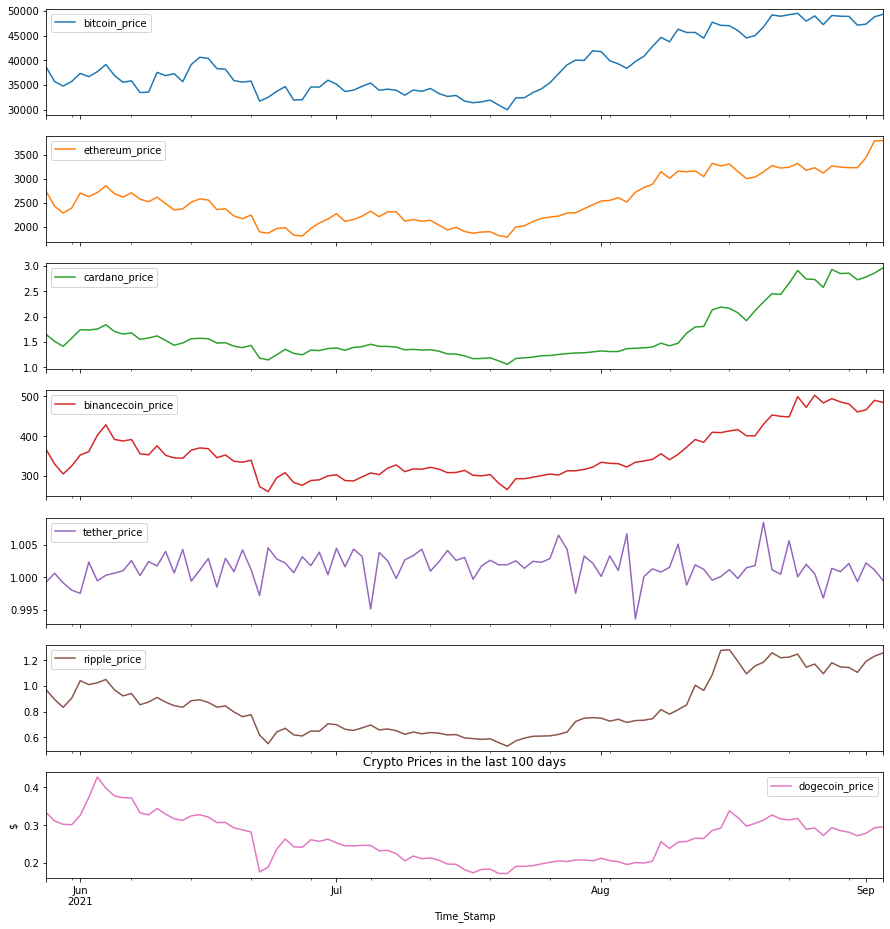

In [9]:
#Visualize the prices of all cryto we selected

all_df.plot(x='Time_Stamp', y= list(all_df.columns[1:8]), subplots = True, figsize = (15,16))
plt.ylabel('$')
plt.title("Crypto Prices in the last 100 days")
plt.show()

In [10]:
# Add two featuers: twitter_followers_diff & reddit_subscribers_diff to reflect popularity 

all_df['twitter_followers_diff'] = all_df['twitter_followers'].diff()
all_df['reddit_subscribers_diff'] = all_df['reddit_subscribers'].diff()

#drop the first row since the diff columns would be NA
all_df = all_df[1:]

In [11]:
#Scale the data except for bitcoin

scaler = MinMaxScaler()
all_df_scaled = pd.DataFrame(scaler.fit_transform(all_df.iloc[:,2:]), columns = all_df.columns[2:])
all_df_scaled = all_df.iloc[:,:2].reset_index(drop=True).join(all_df_scaled)
all_df_scaled

,Time_Stamp,bitcoin_price,ethereum_price,cardano_price,binancecoin_price,tether_price,ripple_price,dogecoin_price,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,twitter_followers_diff,reddit_subscribers_diff
0,2021-05-29,35710.220937,0.319445,0.239022,0.285735,0.473386,0.484730,0.544469,0.000000,0.518337,0.528646,0.000000,0.708937,0.000942,0.497834
1,2021-05-30,34775.079413,0.250036,0.186685,0.183823,0.374042,0.403127,0.510085,0.000092,0.429095,0.533711,0.016333,0.655683,0.000959,0.470835
2,2021-05-31,35714.752020,0.300691,0.271288,0.265457,0.298786,0.497871,0.505072,0.000155,0.564792,0.363082,0.031475,0.612113,0.000925,0.415824
3,2021-06-01,37340.679266,0.457111,0.358943,0.379298,0.265090,0.679267,0.603705,0.000204,0.555420,0.284488,0.046576,0.697503,0.000908,0.413947
4,2021-06-02,36680.068202,0.419192,0.356065,0.414826,0.588775,0.639131,0.787226,0.000267,0.185004,0.206652,0.065996,0.654086,0.000925,0.613341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2021-08-30,48907.270731,0.719807,0.945341,0.909167,0.574715,0.816224,0.427810,0.993422,0.370416,0.018083,0.967890,0.158191,0.002547,0.049668
94,2021-08-31,47124.254225,0.719482,0.876558,0.826237,0.387244,0.765701,0.391078,0.992714,0.564792,0.045849,0.975394,0.158579,0.000000,0.063240
95,2021-09-01,47335.420299,0.823483,0.905648,0.847969,0.580191,0.879682,0.417093,0.996431,0.394866,0.030317,0.982591,0.142016,0.005308,0.049090
96,2021-09-02,48823.055210,0.998656,0.946719,0.946737,0.508008,0.933385,0.473663,0.998167,0.370416,0.091262,0.991639,0.107501,0.002932,0.134565


<AxesSubplot:>

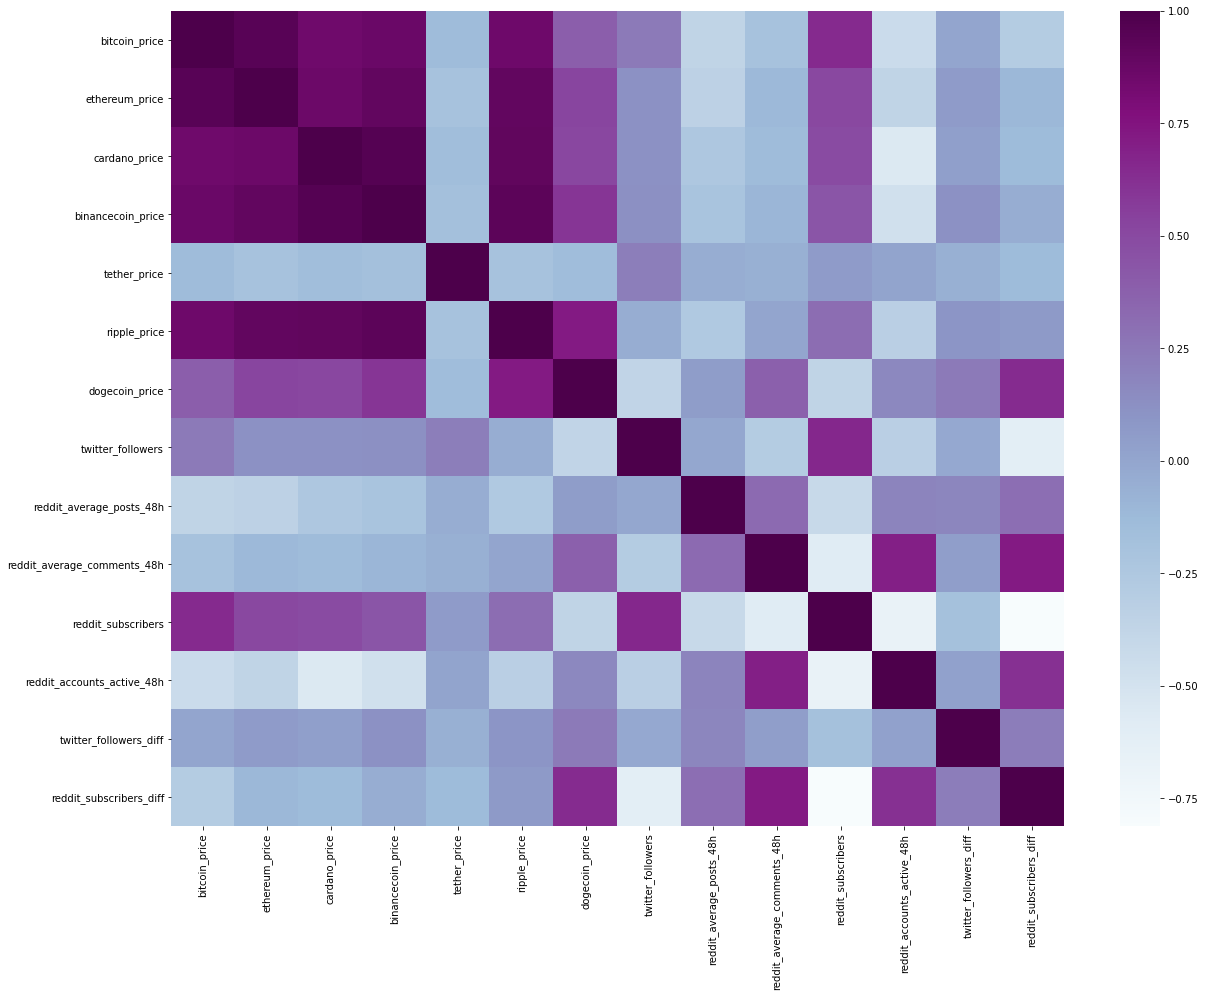

In [19]:
#Correlation between features

plt.figure(figsize=(20,15))
sns.heatmap(all_df_scaled.corr(), cmap="BuPu")

In [13]:
# I am using features from a day ago to predict bitcoin price
# Move Bitcoin price to a day before

all_df_shifted = all_df_scaled.copy()
for i in range(0,97):
    all_df_shifted.at[i, 'bitcoin_price'] = all_df_shifted.at[i+1, 'bitcoin_price']
# zeroing the last bitcoin_price since it's shifted    
all_df_shifted.at[97, 'bitcoin_price'] = 0
all_df_shifted

,Time_Stamp,bitcoin_price,ethereum_price,cardano_price,binancecoin_price,tether_price,ripple_price,dogecoin_price,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,twitter_followers_diff,reddit_subscribers_diff
0,2021-05-29,34775.079413,0.319445,0.239022,0.285735,0.473386,0.484730,0.544469,0.000000,0.518337,0.528646,0.000000,0.708937,0.000942,0.497834
1,2021-05-30,35714.752020,0.250036,0.186685,0.183823,0.374042,0.403127,0.510085,0.000092,0.429095,0.533711,0.016333,0.655683,0.000959,0.470835
2,2021-05-31,37340.679266,0.300691,0.271288,0.265457,0.298786,0.497871,0.505072,0.000155,0.564792,0.363082,0.031475,0.612113,0.000925,0.415824
3,2021-06-01,36680.068202,0.457111,0.358943,0.379298,0.265090,0.679267,0.603705,0.000204,0.555420,0.284488,0.046576,0.697503,0.000908,0.413947
4,2021-06-02,37685.717982,0.419192,0.356065,0.414826,0.588775,0.639131,0.787226,0.000267,0.185004,0.206652,0.065996,0.654086,0.000925,0.613341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2021-08-30,47124.254225,0.719807,0.945341,0.909167,0.574715,0.816224,0.427810,0.993422,0.370416,0.018083,0.967890,0.158191,0.002547,0.049668
94,2021-08-31,47335.420299,0.719482,0.876558,0.826237,0.387244,0.765701,0.391078,0.992714,0.564792,0.045849,0.975394,0.158579,0.000000,0.063240
95,2021-09-01,48823.055210,0.823483,0.905648,0.847969,0.580191,0.879682,0.417093,0.996431,0.394866,0.030317,0.982591,0.142016,0.005308,0.049090
96,2021-09-02,49338.784652,0.998656,0.946719,0.946737,0.508008,0.933385,0.473663,0.998167,0.370416,0.091262,0.991639,0.107501,0.002932,0.134565


In [14]:
# Now we can start training and testing
# I will use the first 80% of data to train, and use the last 20% to test

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train_df, test_df = train_test_split(all_df_shifted[:-1])

X_train = train_df.drop('bitcoin_price', axis=1)
X_train.drop(['Time_Stamp'], axis =1, inplace = True)
y_train = train_df['bitcoin_price']
X_test = train_df.drop('bitcoin_price', axis=1)
X_test.drop(['Time_Stamp'], axis =1, inplace = True)
y_test = train_df['bitcoin_price']

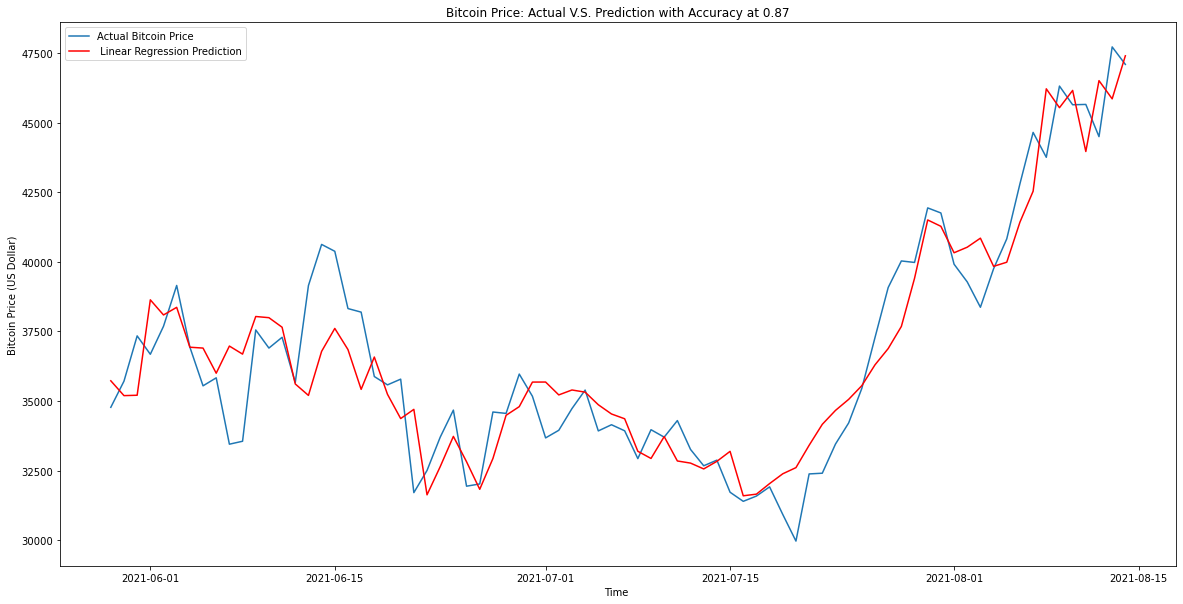

In [42]:
# Basic Linear Regression
# Train & Fit

LR = LinearRegression()
LR.fit(X_train, y_train)
LR_score = LR.score(X_train, y_train)
y_pred = LR.predict(X_train)

# Visualization

plt.figure(figsize = (20,10))
plt.plot(train_df['Time_Stamp'], y_train, label='Actual Bitcoin Price')
plt.plot(train_df['Time_Stamp'], y_pred, 'r', label=' Linear Regression Prediction')
plt.title('Bitcoin Price: Actual V.S. Prediction with Accuracy at ' + str(round(LR_score,2)))
plt.xlabel('Time ')
plt.ylabel('Bitcoin Price (US Dollar)')
plt.legend(loc='upper left')
plt.show()